# Introduction

This notebook demonstrates scraping of data from the [Kitchener Utilities](https://www.kitchenerutilities.ca) website and gas & water bills (pdfs).

## Setup

Fill in your `username` and `password` below, then run all of the cells in the notebook. After running the entire notebook, you'll be able to download your data as a `download.zip` file (containing both a summary `data.csv` and the `*.pdf` statements).

In [1]:
username = ""
password = ""

# Plotting preferences
bin_width = 0.9
alpha = 0.5

%matplotlib inline

import datetime as dt
import os
import shutil
import sys

# Update the path to include the src directory
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..", "src")))

import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from matplotlib import rcParams

import utility_bill_scraper.canada.on.kitchener_utilities as ku

# Load the `.env` file into the environment if it exists
load_dotenv()

rcParams.update({"figure.figsize": (12, 6)})

# If we haven't set a username/password, try getting them from
# environment variables.
if not username:
    username = os.getenv("KITCHENER_UTILITIES_USER")
if not password:
    password = os.getenv("KITCHENER_UTILITIES_PASSWORD", password)

# Set the path where data is saved.
data_path = os.path.join("..", "..", "..", "data")

ku_api = ku.KitchenerUtilitiesAPI(username, password, data_path)

# Get up to 24 statements (the most recent).
updates = ku_api.update(24)
if updates is not None:
    print(f"{ len(updates) } statements_downloaded")
ku_api.history().tail()

,Account Number,Balance Forward,Gas & Water Charges,Gas Charges,Gas Consumption,Stormwater Rate Charges,Total Due,Water Charges,Water Consumption
Issue Date,,,,,,,,,
2021-06-15,110159085.0,0.0,68.12,28.51,9.0,16.39,84.51,39.61,7.0
2021-07-16,110159085.0,0.0,61.49,27.53,6.0,16.39,77.88,33.96,6.0
2021-08-17,110159085.0,0.0,56.16,27.87,2.0,16.39,72.55,28.29,5.0
2021-10-18,110159085.0,0.0,85.91,40.63,42.0,16.39,102.30,45.28,8.0
2021-09-16,110159085.0,0.0,53.51,25.22,4.0,16.39,69.90,28.29,5.0


## Monthly consumption history

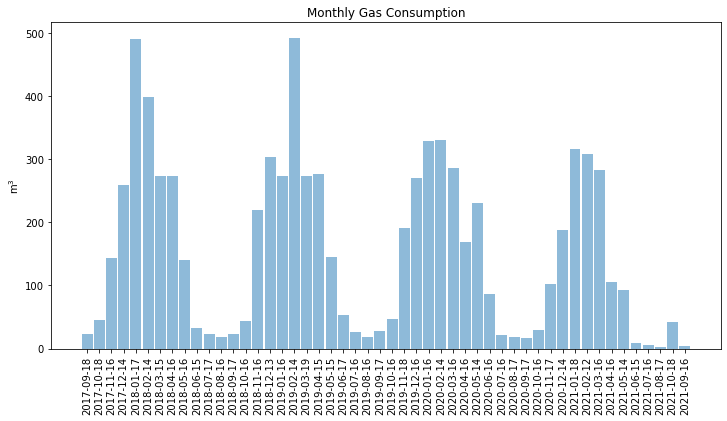

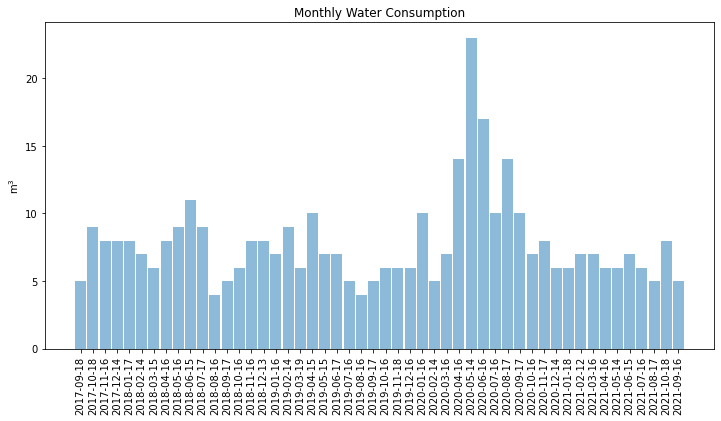

In [2]:
df_ku = ku_api.history()

plt.figure()
plt.bar(df_ku.index, df_ku["Gas Consumption"], width=bin_width, alpha=alpha)
plt.xticks(rotation=90)
plt.title("Monthly Gas Consumption")
plt.ylabel("m$^3$")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "monthly_gas_consumption.svg"), bbox_inches="tight")

plt.figure()
plt.bar(df_ku.index, df_ku["Water Consumption"], width=bin_width, alpha=alpha)
plt.xticks(rotation=90)
plt.title("Monthly Water Consumption")
plt.ylabel("m$^3$")
plt.savefig(os.path.join("images", "monthly_water_consumption.svg"), bbox_inches="tight")

## Annual CO2 emissions

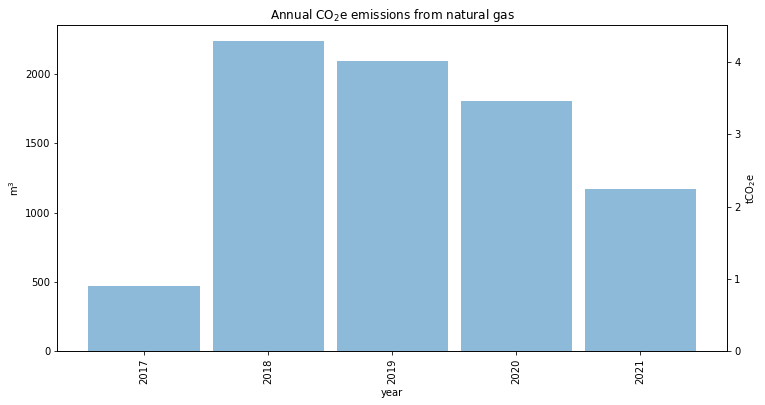

In [3]:
from utility_bill_scraper import GAS_KGCO2_PER_CUBIC_METER

df_ku["kgCO2"] = df_ku["Gas Consumption"] * GAS_KGCO2_PER_CUBIC_METER
df_ku["year"] = [int(x[0:4]) for x in df_ku.index]
df_ku["month"] = [int(x[5:7]) for x in df_ku.index]

plt.figure()
df_ku.groupby("year").sum()["Gas Consumption"].plot.bar(width=bin_width, alpha=alpha)
plt.ylabel("m$^3$")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.ylim([GAS_KGCO2_PER_CUBIC_METER * y / 1e3 for y in ylim])
plt.title("Annual CO$_2$e emissions from natural gas")
plt.savefig(os.path.join("images", "annual_co2_emissions.svg"), bbox_inches="tight")

# CO2 emissions vs previous year

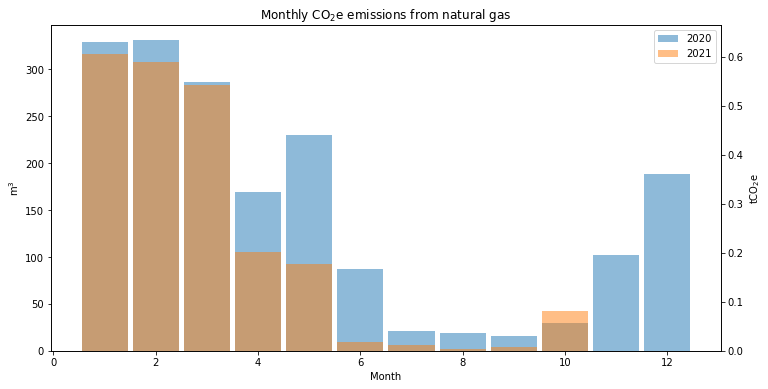

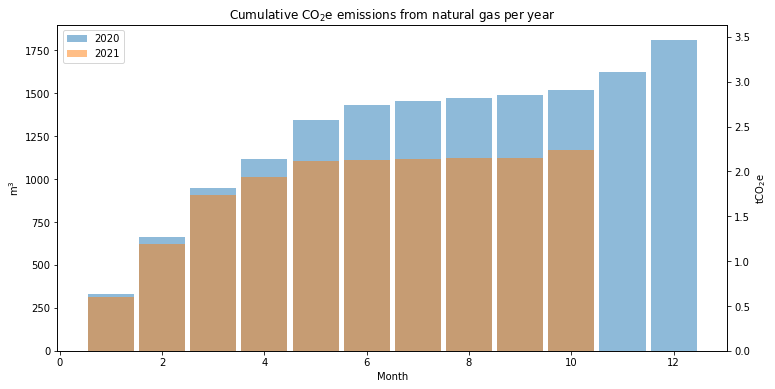

In [4]:
n_years_history = 1

plt.figure()
for year, df_year in df_ku.groupby("year"):
    if year >= dt.datetime.utcnow().year - n_years_history:
        df_year.sort_values("month", inplace=True)
        plt.bar(
            df_year["month"],
            df_year["Gas Consumption"],
            label=year,
            width=bin_width,
            alpha=alpha,
        )
plt.legend()
plt.ylabel("m$^3$")
plt.xlabel("Month")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.ylim([GAS_KGCO2_PER_CUBIC_METER * y / 1e3 for y in ylim])
plt.title("Monthly CO$_2$e emissions from natural gas")
plt.savefig(os.path.join("images", "monthly_co2_emissions.svg"), bbox_inches="tight")

plt.figure()
for year, df_year in df_ku.groupby("year"):
    if year >= dt.datetime.utcnow().year - n_years_history:
        df_year.sort_values("month", inplace=True)
        plt.bar(
            df_year["month"],
            np.cumsum(df_year["Gas Consumption"]),
            label=year,
            width=bin_width,
            alpha=alpha,
        )
plt.legend()
plt.ylabel("m$^3$")
plt.xlabel("Month")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.ylim([GAS_KGCO2_PER_CUBIC_METER * y / 1e3 for y in ylim])
plt.title("Cumulative CO$_2$e emissions from natural gas per year")
plt.savefig(os.path.join("images", "cumulative_co2_emissions.svg"), bbox_inches="tight")

## Save data as `downloads.zip`

Generate a zip file with all of the data
`Right-click` on the file `downloads.zip` in the file browser on the left (it'll be in the notebooks folder).


In [5]:
shutil.make_archive(os.path.join(".", "download"), "zip", data_path)

'C:\\Users\\ryan\\OneDrive\\dev\\python\\utility-bill-scraper\\notebooks\\canada\\on\\download.zip'